##Libraries

In [754]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

#Phone Prices Random Forest

##Set up

In [752]:
use_grid_search = False
use_feature_selection = True

use_mean = True
use_median = False

In [753]:
# use_mean = False
# use_median = False
# choice = ''
# while choice not in ['1', '2', '3']:
#   print('1. Use mean')
#   print('2. Use median')
#   print('3. Use mode')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_mean = True
# elif choice == '2':
#   use_median = True

# choice = ''
# while choice not in ['1', '2']:
#   print('1. Use Grid Search')
#   print('2. Use Default Parameters')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_grid_search = True
# else:
#   use_grid_search = False

##Importing Cleaned Dataset

In [755]:
cleaned = pd.read_csv('Cleaned cleaned_all_phones.csv')

cleaned.head()

,brand,os,inches,battery,battery_type,ram(GB),announcement_date,weight(g),storage(GB),video_720p,...,video_120fps,video_240fps,video_480fps,video_960fps,price,resolution_width,resolution_height,resolution,os_brands,ppi
0,Huawei,Android 5.1,5.0,2200,Li-Po,2,2016-09-01,140.0,16,True,...,False,False,False,False,120.0,720,1280,921600,Android,293.720956
1,LG,Android 7.0,5.3,2700,Li-Ion,2,2016-12-01,140.0,16,False,...,False,False,False,False,100.0,720,1280,921600,Android,277.095242
2,Huawei,Android 7.0,5.2,3000,Li-Ion,4,2017-01-01,147.0,16,False,...,False,False,False,False,420.0,1080,1920,2073600,Android,423.635994
3,Xiaomi,Android 6.0,5.5,4100,Li-Po,4,2017-01-01,165.0,32,True,...,True,False,False,False,150.0,1080,1920,2073600,Android,400.528576
4,Huawei,Android 7.0,5.1,3200,Li-Ion,4,2017-02-01,145.0,32,True,...,False,False,False,False,420.0,1080,1920,2073600,Android,431.942582


##Preparing data for modelling

###Encoding Strings

In [756]:
string_cols = []
for col in cleaned.columns:
  if cleaned.dtypes[col] == 'object':
    string_cols.append(col)
    print(col)

cleaned.head()

brand
os
battery_type
announcement_date
os_brands


,brand,os,inches,battery,battery_type,ram(GB),announcement_date,weight(g),storage(GB),video_720p,...,video_120fps,video_240fps,video_480fps,video_960fps,price,resolution_width,resolution_height,resolution,os_brands,ppi
0,Huawei,Android 5.1,5.0,2200,Li-Po,2,2016-09-01,140.0,16,True,...,False,False,False,False,120.0,720,1280,921600,Android,293.720956
1,LG,Android 7.0,5.3,2700,Li-Ion,2,2016-12-01,140.0,16,False,...,False,False,False,False,100.0,720,1280,921600,Android,277.095242
2,Huawei,Android 7.0,5.2,3000,Li-Ion,4,2017-01-01,147.0,16,False,...,False,False,False,False,420.0,1080,1920,2073600,Android,423.635994
3,Xiaomi,Android 6.0,5.5,4100,Li-Po,4,2017-01-01,165.0,32,True,...,True,False,False,False,150.0,1080,1920,2073600,Android,400.528576
4,Huawei,Android 7.0,5.1,3200,Li-Ion,4,2017-02-01,145.0,32,True,...,False,False,False,False,420.0,1080,1920,2073600,Android,431.942582


In [757]:
encoders = {}
for col in string_cols:
    encoder = TargetEncoder(target_type="continuous", smooth = 5)
    X = cleaned[col].values.reshape(-1, 1)
    encoder.fit(X, cleaned['price'])
    cleaned[col] = encoder.transform(X)
    encoders[col] = encoder

In [758]:
cleaned.columns

Index(['brand', 'os', 'inches', 'battery', 'battery_type', 'ram(GB)',
       'announcement_date', 'weight(g)', 'storage(GB)', 'video_720p',
       'video_1080p', 'video_4K', 'video_8K', 'video_30fps', 'video_60fps',
       'video_120fps', 'video_240fps', 'video_480fps', 'video_960fps', 'price',
       'resolution_width', 'resolution_height', 'resolution', 'os_brands',
       'ppi'],
      dtype='object')

In [759]:
cleaned.isnull().sum()

,0
brand,0
os,0
inches,0
battery,0
battery_type,0
ram(GB),0
announcement_date,0
weight(g),0
storage(GB),0
video_720p,0


##Building Model

###Loading X and y

In [760]:
X = cleaned.drop('price', axis=1)
y = cleaned['price']

In [761]:
print(X.shape)
print(y.shape)

(1401, 24)
(1401,)


###Feature Selection

In [762]:
sfm = SelectFromModel(RandomForestRegressor())
sfm.fit(X, y)

X_new = sfm.transform(X)

Looking at features ranked and the ones selected.

In [763]:
importances = sfm.estimator_.feature_importances_
feature_scores = pd.DataFrame({
    'Feature': X.columns,
      'Importance': importances
}).sort_values(by='Importance', ascending = False),

print(feature_scores)

# Get the indices of the selected features
selected_feature_indices = sfm.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

for col in X.columns:
  if col not in selected_feature_names:
    print("Unselected Features:", col)

(              Feature  Importance
6   announcement_date    0.529880
7           weight(g)    0.074682
23                ppi    0.064984
0               brand    0.053638
3             battery    0.050486
2              inches    0.036895
21         resolution    0.026647
1                  os    0.025957
5             ram(GB)    0.022182
20  resolution_height    0.021660
8         storage(GB)    0.020266
14        video_60fps    0.014041
11           video_4K    0.012084
13        video_30fps    0.009182
4        battery_type    0.007494
9          video_720p    0.007035
15       video_120fps    0.005170
19   resolution_width    0.004866
17       video_480fps    0.003488
18       video_960fps    0.003323
16       video_240fps    0.002921
12           video_8K    0.002413
22          os_brands    0.000635
10        video_1080p    0.000072,)
Unselected Features: os
Unselected Features: inches
Unselected Features: battery_type
Unselected Features: ram(GB)
Unselected Features: storage(GB)

In [764]:
if use_feature_selection:
  X = X_new

###Splitting up training and testing data

In [765]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [766]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1120, 5)
(281, 5)
(1120,)
(281,)


###Scaling Input Data

In [767]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

###Finding best parameters

In [768]:
if use_grid_search:
  param_grid = {
      'max_depth': [50, 100, 150, 200],
      'max_features': ['sqrt', 'log2'],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'bootstrap': [False],
      'max_leaf_nodes': [50, 100, 150, 200],
      'n_estimators': [100, 150, 200, 250],
      'random_state': [42]
  }

In [769]:
if use_grid_search:
  grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, scoring='neg_mean_absolute_error', n_jobs=3, cv = 3, error_score='raise')


In [770]:
if use_grid_search:
  grid_search.fit(X_train, y_train)

In [771]:
if use_grid_search:
  print(grid_search.best_params_)

###Building Random Forest Model

In [772]:
if use_grid_search:
  model = RandomForestRegressor(**grid_search.best_params_)
else: #use best result from grid search
  model = RandomForestRegressor(max_depth = 100, max_features =  'sqrt', min_samples_leaf = 4, min_samples_split = 2, bootstrap= True, max_leaf_nodes=150, n_estimators = 250)


model.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, max_features='sqrt', max_leaf_nodes=150,
                      min_samples_leaf=4, n_estimators=250)

##Testing Model

In [773]:
print(f'Train Accuracy: {model.score(X_train, y_train):.3f}')
print(f'Test Accuracy:  {model.score(X_test, y_test):.3f}')

Train Accuracy: 0.728
Test Accuracy:  0.506


In [774]:
# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_pred):.2f}')

Mean Absolute Error: 74.31
Mean Absolute Percentage Error: 0.32


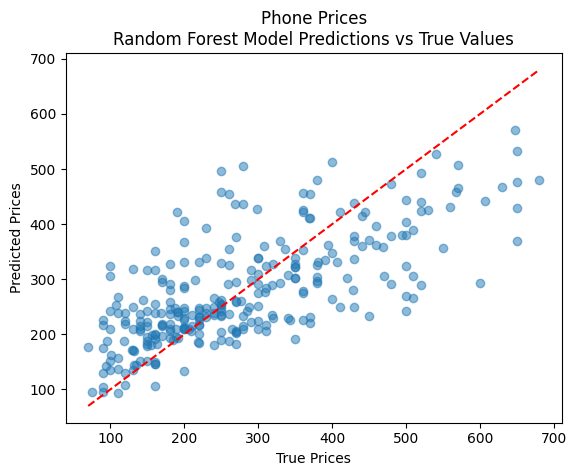

In [775]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Phone Prices\nRandom Forest Model Predictions vs True Values")
plt.show()